In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

For you to run the notebook, follow the next steps:
1. [Click here to have the data](https://drive.google.com/drive/folders/11mXizyarkL6CxAi7oi7oPrqsNaXQx2VE?usp=sharing)
2. Right click -> Add shortcut to drive -> Add shortcut
3. Open this notebook in google colab
4. Accept everything the following cell prompt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/LEGO_minifigures_classification/data"
batch_size = 16
dummy = mpimg.imread(data_dir + "/B. SPIDER-MAN/001.jpg")
img_height, img_width = dummy.shape[0], dummy.shape[1]
AUTOTUNE = tf.data.AUTOTUNE

## Splitting the dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 405 files belonging to 37 classes.
Using 324 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 405 files belonging to 37 classes.
Using 81 files for validation.


In [ ]:
# class names
class_names = train_ds.class_names
class_names

['ANAKIN SKYWALKER',
 'AUNT MAY',
 'B. SPIDER-MAN',
 'BLACK WIDOW',
 'CAPTAIN AMERICA',
 'CARA DUNE',
 'DARTH VADER',
 'EMPEROR PALPATINE',
 'FIREFIGHTER',
 'GENERAL GRIEVOUS',
 'GHOST SPIDER',
 'HAN SOLO',
 'HARRY POTTER',
 'IRON MAN MK 1',
 'IRON MAN MK 41',
 'IRON MAN MK 5',
 'IRON MAN MK 50',
 'JANNAH',
 'KLATOOINIAN RAIDER 1',
 'KLATOOINIAN RAIDER 2',
 'KYLO REN',
 'LUKE SKYWALKER',
 'MACE WINDU',
 'MYSTERIO',
 'OBI-WAN KENOBI',
 'OUTRIDER 1',
 'OUTRIDER 2',
 'OWEN GRADY',
 'R2-D2',
 'RON WEASLEY',
 'SPIDER-MAN',
 'TASKMASTER',
 'THE MANDALORIAN',
 'TRACKER TRAQUEUR RASTREADOR',
 'VENOM',
 'YELENA BELOVA',
 'YODA']

## Visualizing some images

tf.Tensor([15 27 28  1 31 24 29 16 19 31  7 11  7 10 24 26], shape=(16,), dtype=int32)


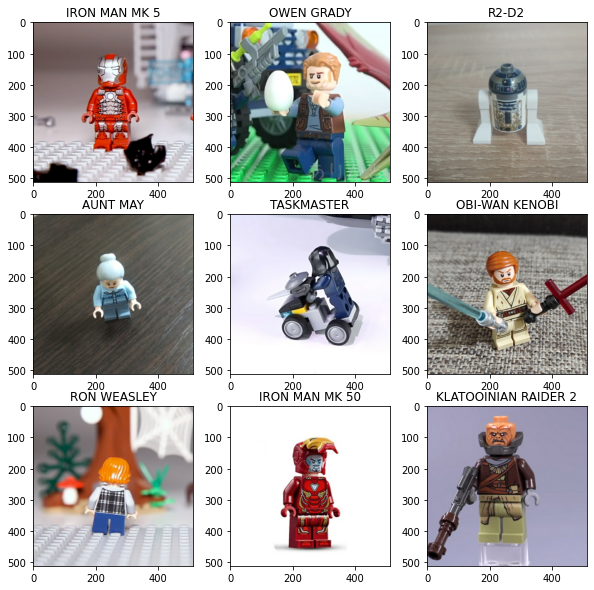

In [ ]:
plt.figure(figsize=(10, 10))
for imgs, labels in train_ds.take(1):
    print(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

## Image augmentation

In [ ]:
class RandomInvert(tf.keras.layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    if  tf.random.uniform([]) < self.factor:
        x = (1-x)
    else:
        x
    return x

In [ ]:
prep_augmentation = tf.keras.Sequential([
  tf.keras.layers.Resizing(img_height, img_width),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  RandomInvert()
])

## Creating the model

In [ ]:
model = tf.keras.Sequential([
    prep_augmentation,
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(37)
])

In [ ]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0015,
    beta_1=0.9,
    beta_2=0.999,
)

## Custom callback if we get a certain accuaracy in train and validation

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    ACCURACY_THRESHOLD=0.7
    VAL_ACCURACY_THRESHOLD=0.32
    def on_epoch_end(self, epoch, logs): 
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if(acc > self.ACCURACY_THRESHOLD and val_acc > self.VAL_ACCURACY_THRESHOLD):   
            print("\nReached  good accs, so stopping training!!")   
            self.model.stop_training = True
mycallback = myCallback()

In [ ]:
model.compile(optimizer = adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ["accuracy"])

In [ ]:
model.summary()

## Second model to try another way to do data augmentation (failed)

In [ ]:
train_ds_ch = train_ds .cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_ch = val_ds .cache().prefetch(buffer_size=AUTOTUNE)
epochs = 200
# history = model.fit(
#     train_ds_ch,
#     validation_data=val_ds_ch,
#     epochs=epochs,
#     callbacks = [mycallback]
# )

In [ ]:
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split = 0.2,)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [ ]:

train_generator = train_datagen.flow_from_directory(
            data_dir,  
            target_size=(img_height, img_width),  
            batch_size=16,
            subset = "training",
            seed=123,
            class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
            data_dir,
            target_size=(img_height, img_width),  
            batch_size=16,
            subset = "validation",
            seed=123,
            class_mode='sparse')

# train_dataset = tf.data.Dataset.from_generator(train_gen, (tf.float32, tf.float32, tf.float32)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_dataset = tf.data.Dataset.from_generator(val_gen, (tf.float32, tf.float32, tf.float32)).cache().prefetch(buffer_size=AUTOTUNE)

Found 343 images belonging to 37 classes.
Found 62 images belonging to 37 classes.


In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(37)
])

In [ ]:
model2.compile(optimizer = adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ["accuracy"])

In [ ]:
history2 = model2.fit(
      train_generator,
      epochs=100,  
      validation_data=validation_generator,
    #   callbacks=[mycallback]
      )

Epoch 1/100
22/22 [==============================] - 100s 4s/step - loss: 80.5641 - accuracy: 0.0437 - val_loss: 3.6107 - val_accuracy: 0.0323
Epoch 2/100
22/22 [==============================] - 103s 5s/step - loss: 3.6313 - accuracy: 0.0350 - val_loss: 3.6099 - val_accuracy: 0.0323
Epoch 3/100
22/22 [==============================] - 97s 4s/step - loss: 3.6049 - accuracy: 0.0321 - val_loss: 3.6088 - val_accuracy: 0.0323
Epoch 4/100
22/22 [==============================] - 97s 4s/step - loss: 3.6000 - accuracy: 0.0437 - val_loss: 3.6077 - val_accuracy: 0.0323
Epoch 5/100
22/22 [==============================] - 98s 4s/step - loss: 3.5905 - accuracy: 0.0496 - val_loss: 3.6067 - val_accuracy: 0.0323
Epoch 6/100
22/22 [==============================] - 98s 4s/step - loss: 3.5555 - accuracy: 0.0496 - val_loss: 3.6055 - val_accuracy: 0.0323
Epoch 7/100
22/22 [==============================] - 101s 5s/step - loss: 3.5643 - accuracy: 0.0292 - val_loss: 3.6051 - val_accuracy: 0.0323
Epoch 8/1